# Filtering our set of final tags

In [1]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools
from collections import Counter

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile
import collections

from run_inference import predict_star, predict
import pandas as pd
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Functions to view image

In [2]:
# read in hdf5 file
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))

In [5]:
# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    w, h = im.shape[:2]
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgbs(im):
    n, w, h = im.shape[:3]
    ret = np.empty((n, w, h, 3), dtype=np.uint8)
    ret[:, :, :, 0] = im[:,:,:,0]
    ret[:, :, :, 1] = im[:,:,:,0]
    ret[:, :, :, 2] = im[:,:,:,0]
    return ret

# from https://gist.github.com/yusugomori/4462221
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [6]:
def si(idx):
    chk = idx/5000
    i = idx % 5000
    plt.imshow(to_rgb(image_hdf5['Chunk{}'.format(chk)][i][:,:,0]), cmap=mpl.cm.gray) 

# Process tags by frequency and spelling

## Spell checking stems

In [7]:
fn = "/data/nearest_neighbor_tagging/tags/architecture_top20.pkl"
tags = pickle.load(open(fn, 'r'))
print len(tags.keys())
tags[tags.keys()[0]]

104519


[(u'place', 12, ['placing', 'places']),
 (u'premier', 12, ['premieres', 'premiers', 'premiere']),
 (u'san', 8, ['sans']),
 (u'present', 8, ['presenter', 'presentation', 'presentment']),
 (u'church', 8, ['churches']),
 (u'grand', 8, ['grands']),
 (u'sous', 7),
 (u'long', 7),
 (u'part', 7),
 (u'edific', 6, ['edifices', 'edifice']),
 (u'princip', 6, ['principal']),
 (u'land', 6, ['lands']),
 (u'natur', 6, ['nature', 'natural', 'natures']),
 (u'fade', 5, ['fades']),
 (u'tradit', 5, ['traditions', 'tradition']),
 (u'servic', 5, ['services', 'service']),
 (u'lieu', 5),
 (u'extrem', 5, ['extremity', 'extremes', "extremity's", 'extreme']),
 (u'religi', 5, ["religious's", 'religious']),
 (u'main', 5, ['mains', 'mainly'])]

In [3]:
import enchant
import difflib
br = enchant.Dict("en_GB")
en = enchant.Dict("en_US")

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [540]:
stems_to_words = collections.defaultdict(lambda: set())
stems_to_word_keys = set()
for img in tags:
    for word_tuple in tags[img]:
        stems_to_word_keys.add(word_tuple[0])
        if len(word_tuple) == 3:  # suggestions
            stems_to_words[word_tuple[0]].update(word_tuple[-1])           

len(stems_to_word_keys)

6811

In [27]:
def get_new_stems(fn):
    print fn
    tags = pickle.load(open(fn, 'r'))

    stems_to_words = collections.defaultdict(lambda: set())
    stems_to_word_keys = set()
    for img in tags:
        for word_tuple in tags[img]:
            stems_to_word_keys.add(word_tuple[0])
            if len(word_tuple) == 3:  # suggestions
                stems_to_words[word_tuple[0]].update(word_tuple[-1])           

    
    old_to_new_stem = {}

    stem_in = 0
    no_unstemmed_good = 0
    no_unstemmed_bad = 0
    unstemmed_good = 0
    stem_unstem_sugg = 0
    space = 0
    other = 0
    ctr = 0
    question = 0

    for stem in stems_to_word_keys:
        ctr += 1
        stem_old = stem

        # replace space with a hyphen to make it more searchable
        if ' ' in stem:
            stem = stem.replace(' ', '-')
            #print stem_old, stem

        # if stem in dictionary, use the stem because it's short and is a word
        if br.check(stem): 
            old_to_new_stem[stem_old] = stem  
            stem_in += 1
            #print stem

        # there are no unstemmed words from the OCR
        elif len(stems_to_words[stem]) == 0: 
            if not br.suggest(stem): 
                old_to_new_stem[stem_old] = ""
                continue
            new_word = br.suggest(stem)[0].lower()
            new_score = enchant.utils.levenshtein(stem, new_word)

            if new_score <= 3: 
                old_to_new_stem[stem_old] = new_word
                #print stem, new_word
                no_unstemmed_good += 1

            else: 
                old_to_new_stem[stem_old] = ""  # throw away
                no_unstemmed_bad += 1

        # there are unstemmed words from the OCR
        else: 
            # unstem is the shortest word in the list of original words
            unstem = min(stems_to_words[stem], key=len)

            # unstem is in the dictionary
            if br.check(unstem): 
                old_to_new_stem[stem_old] = unstem
                unstemmed_good += 1
                continue

            # unstem and stem are both not in the dictionary
            # remove punctuation since this seems to help
            stem_nopunct = stem.replace('-', '').replace('\'', '')
            unstem_nopunct = unstem.replace('-', '').replace('\'', '')

            # get suggestion
            stem_suggs = br.suggest(stem_nopunct)
            unstem_suggs = br.suggest(unstem_nopunct)
            if len(stem_suggs) == 0 or len(unstem_suggs) == 0: 
                old_to_new_stem[stem_old] = ""
                continue

            stem_sugg = stem_suggs[0].lower()
            unstem_sugg = unstem_suggs[0].lower()

            # take the suggestion, since stem and unstem agree on the suggestion
            if stem_sugg == unstem_sugg: 
                old_to_new_stem[stem_old] = stem_sugg  
                stem_unstem_sugg  += 1
                continue

            # if stem agrees with its suggestion, take that; then if unstem agrees with its suggestion, take that
            if stem == stem_sugg: 
                old_to_new_stem[stem_old] = stem_sugg
                #print stem_sugg
            elif unstem == unstem_sugg: 
                old_to_new_stem[stem_old] = unstem_sugg
                #print unstem_sugg

            # both stem and unstem don't agree with their suggestions
            else:   
                stem_score = enchant.utils.levenshtein(stem, stem_sugg)
                unstem_score = enchant.utils.levenshtein(unstem, unstem_sugg)

                # take whichever suggestion is closest to its original
                if stem_score < unstem_score:
                    old_to_new_stem[stem_old] = stem_sugg
                elif stem_score > unstem_score:
                    old_to_new_stem[stem_old] = unstem_sugg

                # if distances are equal, how do we break ties
                else:
                    if en.check(stem_nopunct): 
                        # print stem, stem_sugg, stem_score, unstem, unstem_sugg, unstem_score
                        # print stem_sugg
                        if stem_nopunct == stem_sugg.replace('-', '').replace('\'', ''): 
                            old_to_new_stem[stem_old] = stem_nopunct
                        else: old_to_new_stem[stem_old] = stem_old
                    elif en.check(stem_old): old_to_new_stem[stem_old] = stem_old                            
                    elif en.check(unstem): old_to_new_stem[stem_old] = unstem
                    else: old_to_new_stem[stem_old] = stem_sugg

    # throw away words less than 3 characters in length, and replace 'franc' with 'france'
    for stem in old_to_new_stem:
        if len(old_to_new_stem[stem]) < 3: 
            old_to_new_stem[stem] = ""
        if old_to_new_stem[stem] == 'franc':
            old_to_new_stem[stem] = 'france'

    print ctr, space, stem_in, no_unstemmed_good, no_unstemmed_bad, unstemmed_good, stem_unstem_sugg, other, question
    
    
    new_tags = {}
    for img in tags:
        new_tags[img] = []
        for word_tup in tags[img]:
            new_word = old_to_new_stem[word_tup[0]]
            if new_word == '': continue
            new_tags[img].append((str(new_word), word_tup[1]))
        
    return old_to_new_stem, new_tags

## Replace all tags with these new stems

In [542]:
new_tags = {}
for img in tags:
    new_tags[img] = []
    for word_tup in tags[img]:
        new_word = old_to_new_stem[word_tup[0]]
        if new_word == '': continue
        new_tags[img].append((str(new_word), word_tup[1]))

In [678]:
x = np.random.choice(new_tags.keys())
print new_tags[x]

[('present', 8), ('interest', 5), ('occasion', 5), ('ion', 5), ('monument', 5), ('hand', 4), ('taint', 4), ('form', 4), ('city', 4), ('koran', 4), ('gen', 4), ('tour', 4), ('side', 4), ('public', 4), ('christian', 4), ('good', 4), ('principe', 4), ('long', 4), ('great', 4), ('land', 4)]


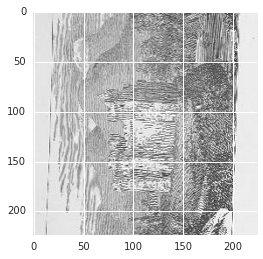

In [677]:
si(x)

## Words to picture mappings

In [713]:
words_to_img = collections.defaultdict(lambda: [])
for img in new_tags:
    for word_tup in new_tags[img]:
        words_to_img[word_tup[0]].append(img)
        
a = words_to_img.keys()
for key in a:
    if len(words_to_img[key]) > 40: 
        print key

lord
deli
dell
scholar
wooden
charter
millet
elegant
second
chine
china
herr
i'd
military
golden
stern
unit
music
telegraph
capital
holy
glass
maximilian
example
hog
auger
travel
machine
turk
beauty
eland
wine
township
silver
prize
bartok
cathedral
mdt
foundation
strata
purpose
nigel
instruct
service
master
gilbert
geneva
trek
tree
person
object
letter
professor
camp
prig
busy
rich
plate
agni
traverse
fair
result
bess
best
lott
xvi
glasgow
nature
souvenir
extent
veer
country
alcuin
erst
brindle
rend
union
privilege
fry
life
eastern
lift
child
commerce
kennan
castro
employ
viii
european
i'm
tune
birmingham
previous
han
prison
east
hat
right
people
crown
memorable
son
fabric
avail
happy
leiden
verde
liberal
exist
floor
republic
intent
time
chair
hole
vet
leave
burch
melt
ground
honour
benson
virtue
winter
grosser
edinburgh
date
dove
mange
kong
course
magog
nation
revers
quarter
square
siege
flanders
spanish
vote
open
city
boulevard
convent
savant
note
opposite
theiler
average
merit
brigh

In [2]:
print words_to_img["john"]

NameError: name 'words_to_img' is not defined

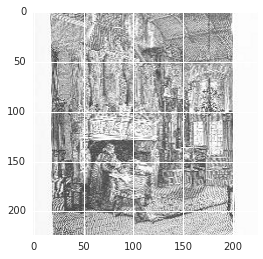

In [803]:
si(526832)

## Only keep the most common

In [302]:
all_stems = [tup[0] for key in new_tags for tup in new_tags[key]]
all_stems_ct = Counter(all_stems)
len(all_stems_ct.keys())

all_stems_ct.most_common()

[('great', 152570),
 ('good', 100487),
 ('time', 98368),
 ('long', 68374),
 ('large', 63346),
 ('hand', 52494),
 ('part', 51604),
 ('year', 50947),
 ('john', 47518),
 ('london', 46357),
 ('franc', 46212),
 ('place', 45695),
 ('england', 44765),
 ('young', 41053),
 ('present', 40490),
 ('office', 39782),
 ('history', 39128),
 ('small', 39061),
 ('land', 37877),
 ('house', 37461),
 ('grand', 35156),
 ('general', 33988),
 ('whole', 33592),
 ('nation', 32552),
 ('friend', 32294),
 ('life', 32061),
 ('ion', 29090),
 ('nature', 28160),
 ('work', 28137),
 ('english', 27967),
 ('public', 27808),
 ('william', 26086),
 ('force', 25331),
 ('chapter', 24202),
 ('name', 23786),
 ('premier', 23410),
 ('country', 23353),
 ('beauty', 22693),
 ('king', 21922),
 ('poor', 21780),
 ('fort', 21732),
 ('thing', 21255),
 ('', 19748),
 ('interest', 19739),
 ('george', 18655),
 ('side', 18505),
 ('white', 18389),
 ('lady', 18284),
 ('high', 17432),
 ('main', 17247),
 ('point', 16873),
 ('state', 16583),
 ('sch

In [91]:
old_new, tags = get_new_stems("/data/nearest_neighbor_tagging/tags/diagrams_top20.pkl")

/data/nearest_neighbor_tagging/tags/diagrams_top20.pkl
8225 0 4083 1289 61 1838 228 0 0


In [89]:
br.suggest("vanishing-point")

[]

In [81]:
x = np.random.choice(tags.keys())
print tags[x]

[('great', 11), ('time', 7), ('whose', 6), ('thing', 6), ('year', 6), ('thou', 6), ('jonson', 6), ('enter', 5), ('hand', 5), ('right', 5), ('good', 5), ('native', 5), ('whale', 5), ('music', 4), ('work', 4), ('beauty', 4), ('green', 4), ('london', 4), ('sealant', 4), ('head', 4)]


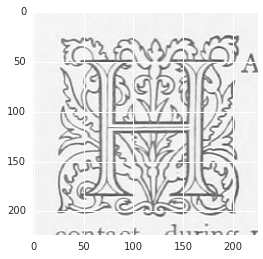

In [82]:
si(x)

In [92]:
all_stems = [tup[0] for key in tags for tup in tags[key]]
all_stems_ct = Counter(all_stems)
len(all_stems_ct.keys())

all_stems_ct.most_common()

[('great', 38533),
 ('part', 31325),
 ('large', 30344),
 ('small', 28500),
 ('form', 24688),
 ('differ', 23876),
 ('side', 15867),
 ('time', 14803),
 ('work', 13522),
 ('rock', 13277),
 ('line', 12149),
 ('upper', 11941),
 ('water', 11682),
 ('mine', 11666),
 ('long', 9896),
 ('general', 9817),
 ('point', 9448),
 ('good', 9340),
 ('angle', 9269),
 ('ion', 9021),
 ('present', 8918),
 ('geology', 8916),
 ('direct', 8691),
 ('place', 7834),
 ('thick', 7552),
 ('consider', 7397),
 ('origin', 7324),
 ('inch', 7063),
 ('whole', 7030),
 ('mass', 6896),
 ('posit', 6849),
 ('nature', 6126),
 ('high', 6088),
 ('land', 5942),
 ('metal', 5905),
 ('certain', 5904),
 ('ordinary', 5459),
 ('plate', 5443),
 ('stone', 5389),
 ('various', 5227),
 ('right', 5192),
 ('surface', 5066),
 ('quantity', 4967),
 ('import', 4936),
 ('main', 4768),
 ('parallel', 4537),
 ('distance', 4238),
 ('section', 4218),
 ('miner', 4182),
 ('england', 4030),
 ('john', 4006),
 ('fine', 3800),
 ('london', 3652),
 ('engine', 35

## Get tags for all 10 categories

In [29]:
category_to_tag = {}
not_running = {"decorations", "miniatures"}
files = glob.glob("/data/nearest_neighbor_tagging/tags/*.pkl")
for fn in files:
    category = os.path.basename(fn)[:-10]
    if category in not_running: continue
    print category
    
    old_new, tags = get_new_stems(fn)
    category_to_tag[category] = tags

landscapes
/data/nearest_neighbor_tagging/tags/landscapes_top20.pkl
7311 0 3670 1121 21 1408 254 0 0
seals
/data/nearest_neighbor_tagging/tags/seals_top20.pkl
9372 0 4489 1773 80 1849 317 0 0
maps
/data/nearest_neighbor_tagging/tags/maps_top20.pkl
7918 0 3829 1425 36 1568 270 0 0
animals
/data/nearest_neighbor_tagging/tags/animals_top20.pkl
7238 0 3787 1045 19 1491 219 0 0
architecture
/data/nearest_neighbor_tagging/tags/architecture_top20.pkl
6811 0 3416 1062 26 1372 224 0 0
objects
/data/nearest_neighbor_tagging/tags/objects_top20.pkl
8761 0 4412 1325 42 1839 274 0 0
nature
/data/nearest_neighbor_tagging/tags/nature_top20.pkl
6941 0 3505 1103 20 1343 212 0 0
people
/data/nearest_neighbor_tagging/tags/people_top20.pkl
10741 0 5231 1804 62 2103 373 0 0
text
/data/nearest_neighbor_tagging/tags/text_top20.pkl
8903 0 4428 1689 54 1748 274 0 0
diagrams
/data/nearest_neighbor_tagging/tags/diagrams_top20.pkl
8225 0 4083 1289 61 1838 228 0 0


### Most common words across all 10 categories

In [36]:
tag_to_rank = collections.defaultdict(lambda: 0)
for category in category_to_tag:
    tags = category_to_tag[category]
    all_stems = [tup[0] for key in tags for tup in tags[key]]
    all_stems_ct = Counter(all_stems)
    len(all_stems_ct.keys())
    ranking = all_stems_ct.most_common()
    for i in range(len(ranking)):
        tag_to_rank[ranking[i][0]] += i

In [37]:
from Queue import PriorityQueue
q = PriorityQueue()
for tag in tag_to_rank:
    q.put((tag_to_rank[tag], tag))
for i in range(100):
    print q.get()

(51, 'place')
(83, 'land')
(137, 'england')
(149, 'london')
(157, 'side')
(165, 'house')
(185, 'grand')
(190, 'john')
(192, 'general')
(197, 'nature')
(213, 'work')
(219, 'year')
(232, 'form')
(232, 'france')
(240, 'whole')
(261, 'descriptive')
(269, 'beauty')
(277, 'high')
(295, 'name')
(313, 'premier')
(319, 'point')
(346, 'fort')
(351, 'differ')
(366, 'english')
(368, 'equate')
(368, 'main')
(371, 'bodice')
(375, 'water')
(378, 'divisive')
(394, 'import')
(402, 'hand')
(403, 'history')
(408, 'office')
(439, 'callow')
(442, 'country')
(462, 'translator')
(469, 'interest')
(469, 'stone')
(489, 'consider')
(496, 'street')
(517, 'kochab')
(540, 'variant')
(543, 'humbly')
(563, 'fine')
(573, 'nation')
(578, 'delineate')
(597, 'line')
(600, 'geographer')
(600, 'origin')
(620, 'applicable')
(629, 'king')
(643, 'white')
(653, 'city')
(678, 'public')
(698, 'force')
(700, 'right')
(706, 'state')
(708, 'anzac')
(731, 'william')
(737, 'town')
(743, 'crystallography')
(757, 'life')
(761, 'propag

In [35]:
stopwords = {"great", "time", "large", "part", "good", "small", "long", "present", "ion"}
for category in category_to_tag:
    print category
    tags = category_to_tag[category]
    for img in tags:
        tags[img] = [word for word in tags[img] if word[0] not in stopwords]
        if 'franc' in tags[img]:
            tags[img].remove('franc')
            tags[img].append('france')
    category_to_tag[category] = tags

animals
nature
text
people
seals
maps
objects
architecture
landscapes
diagrams


In [42]:
for category in category_to_tag:
    print category
    tags = category_to_tag[category]
    pickle.dump(tags, open("/data/nearest_neighbor_tagging/tags/{}_final.pkl".format(category), 'w'))

animals
nature
text
people
seals
maps
objects
architecture
landscapes
diagrams


In [41]:
len(category_to_tag["animals"].keys())

56233